In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.preprocessing import Imputer
from scipy.stats import skew, norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import repeat
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from matplotlib_venn import venn2, venn3
from sklearn.preprocessing import LabelEncoder

In [2]:
def conv(s):
    if s == '':
        return np.nan
    return float(s.replace(',', '.'))

columns_to_conv = ['Нефть, т', 'Конденсат, т', 'Приемистость, м3/сут', 'Обводненность (вес), %', 'Нефть, м3', 'Жидкость, м3', \
                    'Дебит конденсата', 'Добыча растворенного газа, м3', 'Дебит попутного газа, м3/сут',
                  'Вода, т', 'Жидкость, т', 'Попутный газ, м3', 'Закачка, м3',
       'Природный газ, м3']
convertors = dict(zip(columns_to_conv, repeat(conv.__call__, len(columns_to_conv))))

def conv_date(x):
    if x.day != 1:
        return (x + pd.offsets.MonthBegin(1))
    else:
        return x

In [3]:
df_train = pd.read_csv('input/task_3/train.csv', header = 0 ,encoding = 'cp1251', 
                       parse_dates = ['Дата'], converters= convertors)
df_test_before = pd.read_csv('input/task_3/test_before.csv', header = 0 ,encoding = 'cp1251', 
                             parse_dates = ['Дата'], converters= convertors)
df_test_after = pd.read_csv('input/task_3/test_after_X.csv', header = 0 ,encoding = 'cp1251',
                            parse_dates = ['Дата'], converters= convertors)

In [4]:
df_train['Характер работы'] = df_train['Характер работы'].replace({'НЕФ/НАГ': 'НАГ'})
df_test_before['Характер работы'] = df_test_before['Характер работы'].replace({'НЕФ/НАГ': 'НАГ'})
df_train['Характер работы'] = df_train['Характер работы'].fillna(method = 'ffill')
df_test_before['Характер работы'] = df_test_before['Характер работы'].fillna(method = 'ffill')

In [7]:
df_test_after.iloc[:,:].head()

,Скважина,Дата,Характер работы,"Закачка, м3",group
0,b68bd6ef5017d242,2017-01-01,НАГ,1.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...
1,b68bd6ef5017d242,2017-02-01,НАГ,134.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...
2,b68bd6ef5017d242,2017-03-01,НАГ,461.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...
3,b68bd6ef5017d242,2017-04-01,НАГ,423.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...
4,b68bd6ef5017d242,2017-05-01,НАГ,446.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...


In [40]:
df_train.columns

Index(['Скважина', 'Дата', 'Характер работы', 'Состояние', 'Время работы, ч',
       'Нефть, т', 'Вода, т', 'Жидкость, т', 'Попутный газ, м3', 'Закачка, м3',
       'Природный газ, м3', 'Газ из газовой шапки, м3', 'Конденсат, т',
       'Простой, ч', 'Причина простоя', 'Обводненность (масса), %',
       'Агент закачки', 'Нефть, м3', 'Жидкость, м3',
       'Добыча растворенного газа, м3', 'Тип скважины',
       'Диаметр экспл.колонны', 'Диаметр НКТ', 'Диаметр штуцера',
       'Глубина верхних дыр перфорации', 'Удлинение', 'Способ эксплуатации',
       'Тип насоса', 'Производительность ЭЦН', 'Напор', 'Частота',
       'Коэффициент сепарации', 'Глубина спуска', 'Буферное давление',
       'Давление в линии', 'Пластовое давление', 'Динамическая высота',
       'Затрубное давление', 'Давление на приеме', 'Забойное давление',
       'Дебит нефти', 'Дебит жидкости', 'Обводненность',
       'Состояние на конец месяца', 'Давление наcыщения', 'Газовый фактор',
       'Вязкость нефти в пластовых 

In [6]:
print('shape of train {}'.format(df_train.shape))
print('shape of test before {}'.format(df_test_before.shape))
print('shape of test after {}'.format(df_test_after.shape))

shape of train (15040, 86)
shape of test before (4156, 86)
shape of test after (240, 5)


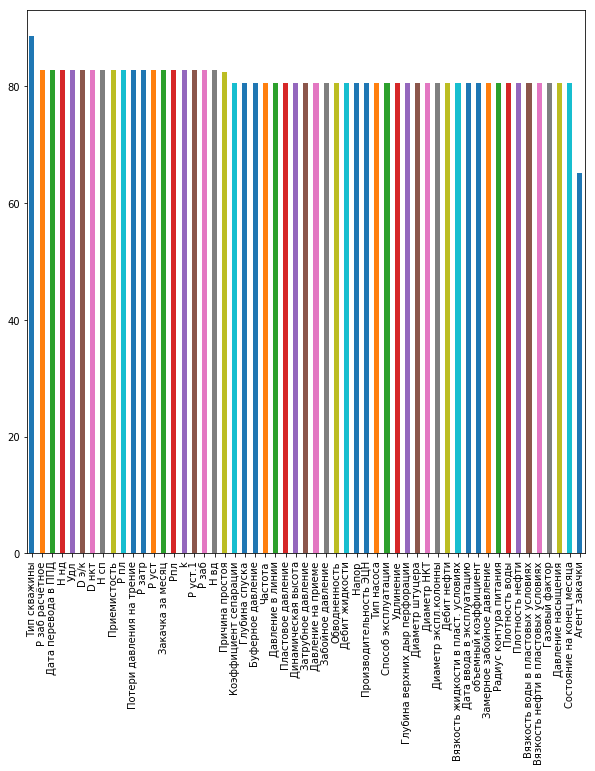

In [5]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (100*df_train.isnull().sum()/df_train.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
fig = plt.figure(figsize=(10,10))
missing_data.loc[missing_data['Percent']>50, 'Percent'].plot.bar()

In [23]:
missing_data.loc[missing_data['Percent'] == 0]

,Total,Percent
"Время работы, ч",0,0.0
"Нефть, т",0,0.0
"Природный газ, м3",0,0.0
"Вода, т",0,0.0
Дата,0,0.0
"Жидкость, т",0,0.0
"Попутный газ, м3",0,0.0
"Закачка, м3",0,0.0
group,0,0.0
"Газ из газовой шапки, м3",0,0.0


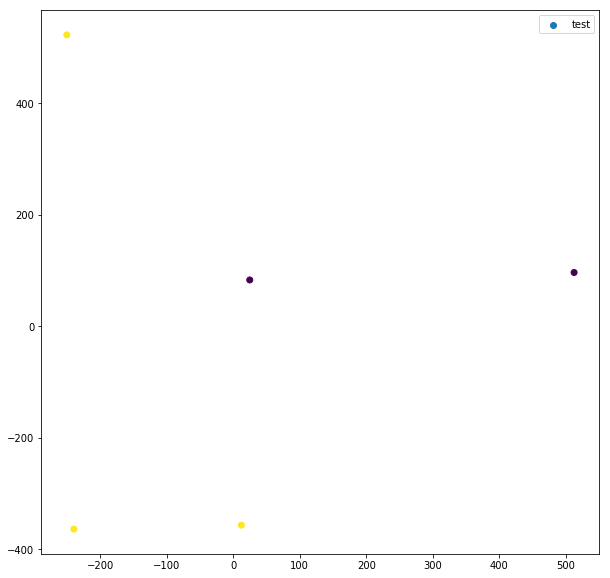

In [22]:
%matplotlib inline
gr = 2
plt.figure(figsize=(10,10))
#plt.scatter(df_train.drop_duplicates('Скважина', 'first')['X'], 
#            df_train.drop_duplicates('Скважина', 'first')['Y'], 
#            c = df_train.drop_duplicates('Скважина', 'first')['gr'], label='train')
plt.scatter(df_test_b_ind.loc[gr].drop_duplicates('Скважина', 'first')['X'], 
            df_test_b_ind.loc[gr].drop_duplicates('Скважина', 'first')['Y'], 
            c = df_test_b_ind.loc[gr].drop_duplicates('Скважина', 'last')['type'],
            label='test')
plt.legend()

In [24]:
df_test_after.head()

,Скважина,Дата,Характер работы,"Закачка, м3",group,gr
0,b68bd6ef5017d242,2017-01-01,НАГ,1.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...,10
1,b68bd6ef5017d242,2017-02-01,НАГ,134.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...,10
2,b68bd6ef5017d242,2017-03-01,НАГ,461.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...,10
3,b68bd6ef5017d242,2017-04-01,НАГ,423.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...,10
4,b68bd6ef5017d242,2017-05-01,НАГ,446.0,baddf234b4fff462a529727cd2c9ad19ccf4d571d420bb...,10


In [12]:
test_before_pr_w = df_test_before.loc[df_test_before['Характер работы'] == 'НЕФ', 'Скважина'].unique().tolist()
test_before_inj_w = df_test_before.loc[df_test_before['Характер работы'] == 'НАГ', 'Скважина'].unique().tolist()
test_after_w = df_test_after['Скважина'].unique().tolist()
train_w = df_train['Скважина'].unique().tolist()

/Users/konstantingopa/anaconda/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


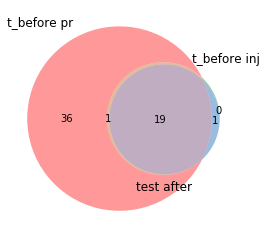

In [27]:
venn3(subsets = [set(test_before_pr_w), set(test_before_inj_w), set(test_after_w)],
     set_labels = ['t_before pr', 't_before inj', 'test after'])

In [29]:
len(test_before_inj_w) == len(test_after_w)

False

In [14]:
lbl1 = LabelEncoder()
#lbl2 = LabelEncoder()
lbl1.fit(df_train['group'].values) 
df_train['gr'] = lbl1.transform(df_train['group'].values)

df_train['type'] = lbl1.fit_transform(df_train['Характер работы'].values)
#lbl2.fit(df_test_before['group'].values)
df_test_before['type'] = lbl1.transform(df_test_before['Характер работы'].values)
df_test_before['gr'] = lbl1.fit_transform(df_test_before['group'].values)
df_test_after['gr'] = lbl1.transform(df_test_after['group'].values)

In [17]:
df_test_b_ind = df_test_before.set_index(['gr', 'Скважина', 'Дата'], drop=False)
df_test_a_ind = df_test_after.set_index(['gr', 'Скважина', 'Дата'], drop=False)
df_train_ind = df_train.set_index(['gr', 'Скважина', 'Дата'], drop=False)

In [10]:
groups_test = df_test_before['gr'].unique().tolist()
groups_train = df_train['gr'].unique().tolist()

In [25]:
idx = pd.IndexSlice

In [24]:
def plot_group_test(group):
    wells = df_test_b_ind.loc[group].index.get_level_values(0).unique()
    fig, ax = plt.subplots(nrows=len(wells), ncols=1, figsize=(10, len(wells)*6), sharex=True) 
    for j, well in enumerate(wells):
        df_test_b_ind.loc[idx[group, well, :]].plot(x= 'Дата', y= ['Жидкость, м3', 'Нефть, м3', 'Закачка, м3'], ax=ax[j]);
        if any(df_test_b_ind.loc[idx[group, well, :], 'Характер работы'].isin(['НАГ'])):
            df_test_a_ind.loc[idx[group, well, :]].plot(x='Дата', y =['Закачка, м3'], ax=ax[j]);
            
def plot_group_train(group):
    wells = df_train_ind.loc[group].index.get_level_values(0).unique()
    fig, ax = plt.subplots(nrows=len(wells), ncols=1, figsize=(10, len(wells)*6), sharex=True) 
    for j, well in enumerate(wells):
        df_train_ind.loc[idx[group, well, :]].plot(x= 'Дата', y= ['Жидкость, м3', 'Нефть, м3', 'Закачка, м3'], ax=ax[j]);
        #if any(df_test_b_ind.loc[idx[group, well, :], 'Характер работы'].isin(['НАГ'])):
         #   df_test_a_ind.loc[idx[group, well, :]].plot(x='Дата', y =['Закачка, м3'], ax=ax[j]);

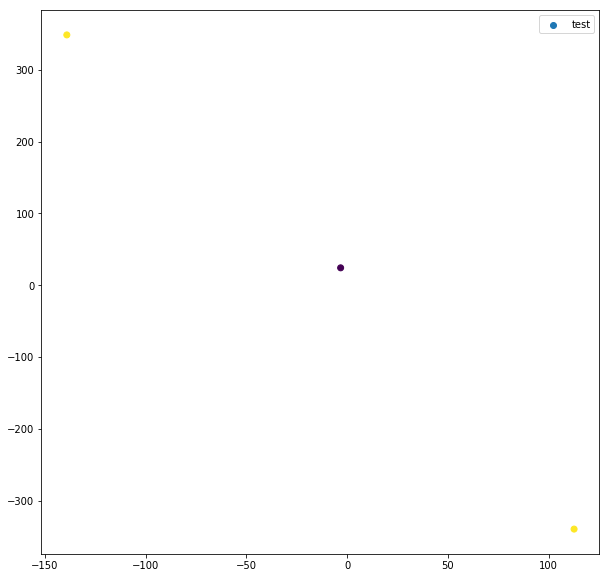

In [31]:
%matplotlib inline
gr = 7
plt.figure(figsize=(10,10))
#plt.scatter(df_train.drop_duplicates('Скважина', 'first')['X'], 
#            df_train.drop_duplicates('Скважина', 'first')['Y'], 
#            c = df_train.drop_duplicates('Скважина', 'first')['gr'], label='train')
plt.scatter(df_test_b_ind.loc[gr].drop_duplicates('Скважина', 'first')['X'], 
            df_test_b_ind.loc[gr].drop_duplicates('Скважина', 'first')['Y'], 
            c = df_test_b_ind.loc[gr].drop_duplicates('Скважина', 'last')['type'],
            label='test')
plt.legend()

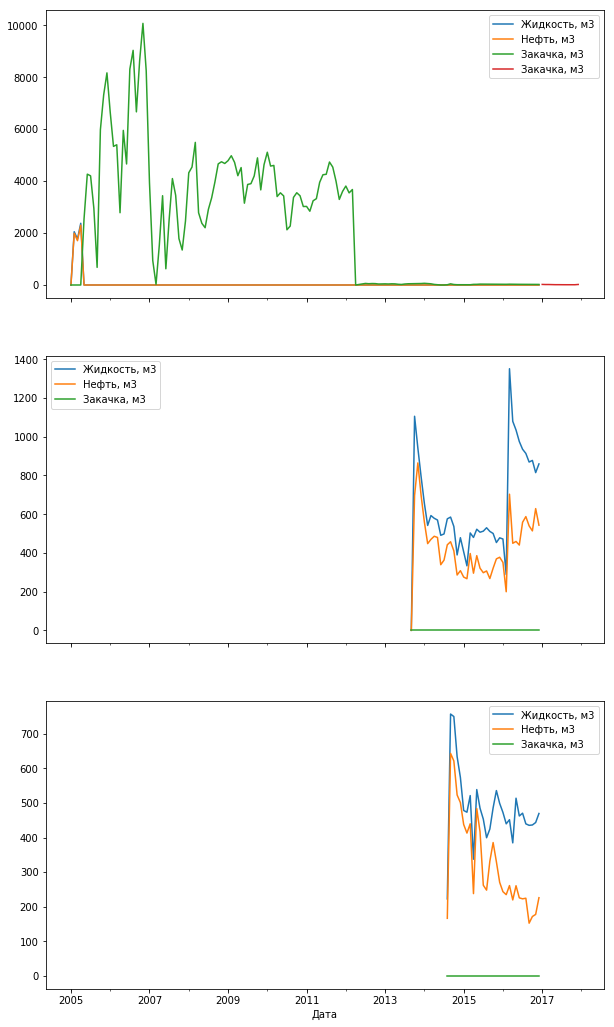

In [32]:
plot_group_test(7)

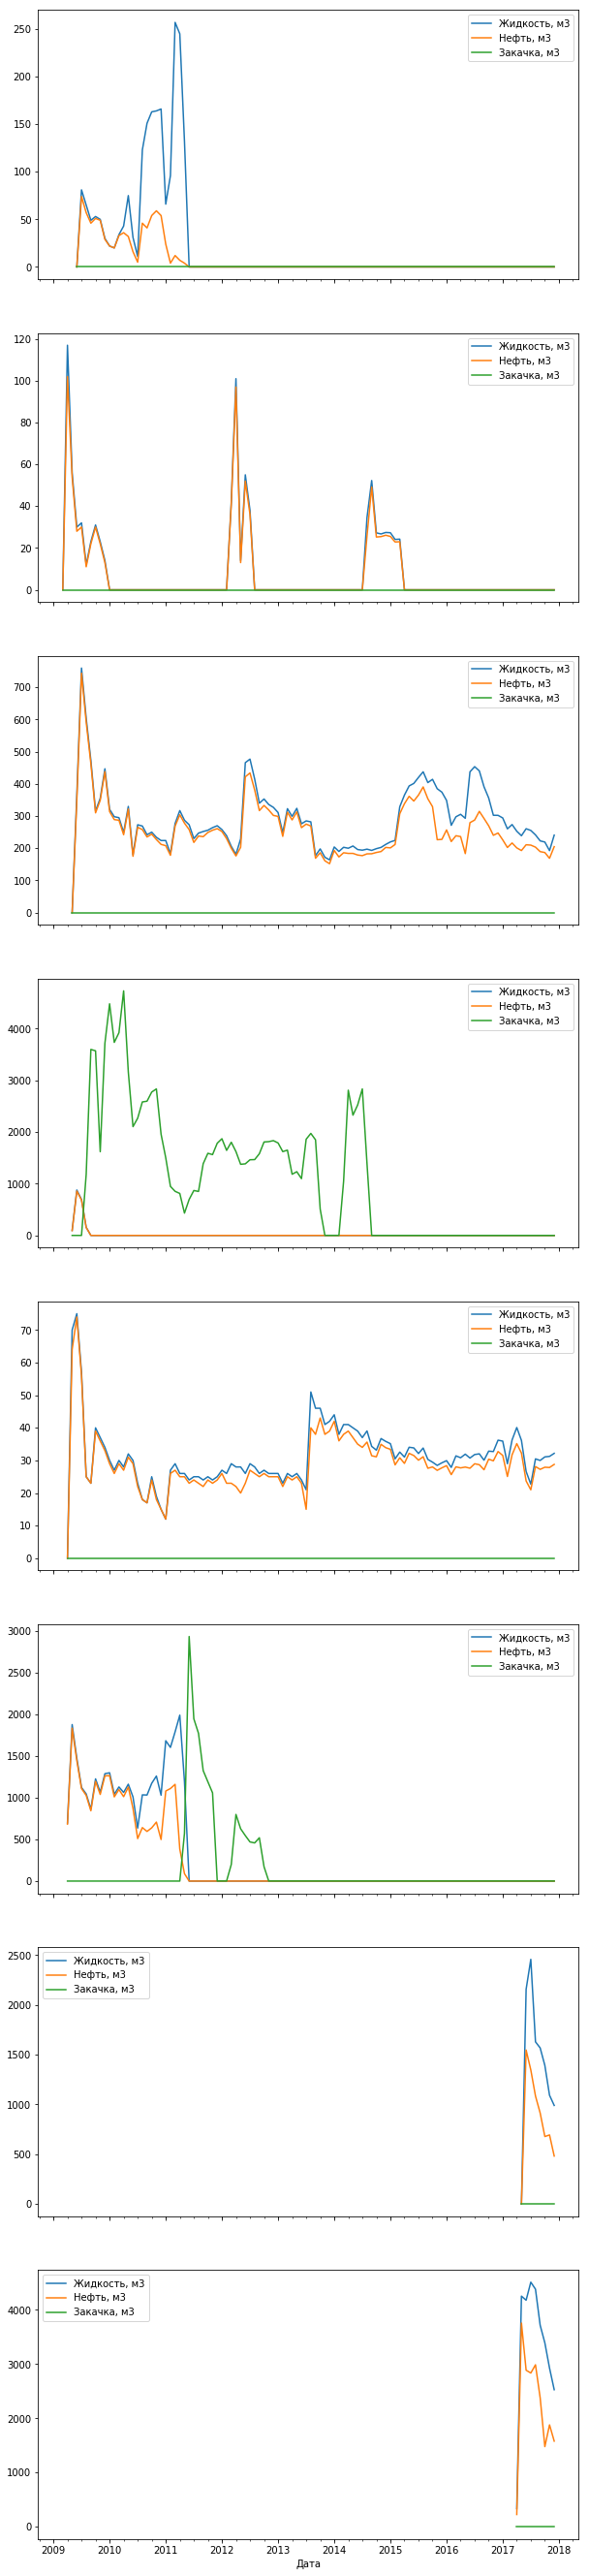

In [65]:
plot_group_train(24)

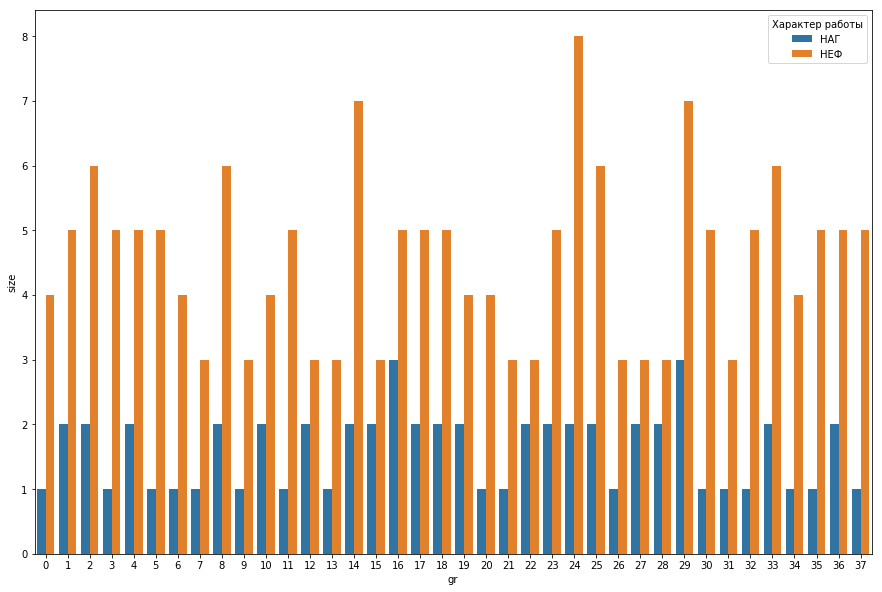

In [90]:
fig = plt.figure(figsize=(15,10))
df_type_size = df_train.drop_duplicates(subset=['Скважина', 'Характер работы']).groupby(['gr', 'Характер работы']).size().rename('size').reset_index()
sns.barplot(data = df_type_size, x = 'gr', y = 'size', hue = 'Характер работы');

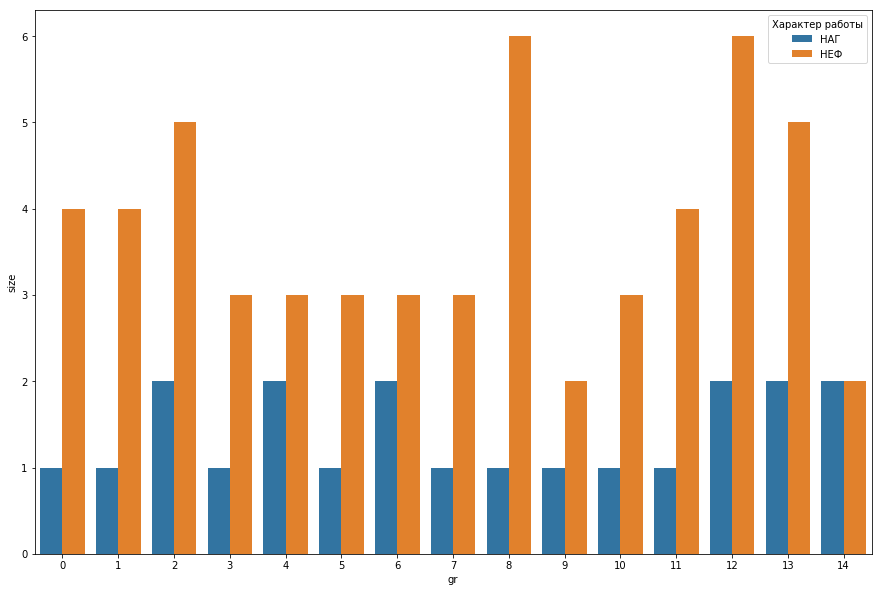

In [91]:
fig = plt.figure(figsize=(15,10))
df_test_type_size = df_test_before.drop_duplicates(subset=['Скважина', 'Характер работы']).groupby(['gr', 'Характер работы']).size().rename('size').reset_index()
sns.barplot(data = df_test_type_size, x = 'gr', y = 'size', hue = 'Характер работы');